# Load Libraries and Data

In [1]:
#Import requisite libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
#Read data from each individual spreadsheet and aggregate into one dataframe
years = ['2016','2017','2018']

df = pd.DataFrame([])

for year in years: 
    tempdf = pd.read_csv(year+'_ob_report.csv')
    df = pd.concat([df,tempdf], sort=True)

df.reset_index(drop=True,inplace=True)

In [3]:
#Examine dataframe for missing values and datatype
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 10 columns):
Active                 910 non-null object
Causative Agent        910 non-null object
Date Declared Over     889 non-null object
Date Outbreak Began    910 non-null object
Etiological Agent2     130 non-null object
Institution Address    910 non-null object
Institution Name       910 non-null object
Outbreak Setting       910 non-null object
Type of Outbreak       910 non-null object
Unnamed: 9             1 non-null object
dtypes: object(10)
memory usage: 71.2+ KB
None


,Active,Causative Agent,Date Declared Over,Date Outbreak Began,Etiological Agent2,Institution Address,Institution Name,Outbreak Setting,Type of Outbreak,Unnamed: 9
0,N,Influenza A (H3N2),2017-01-20,2016-12-31,NaN,551 Conlins Rd,Extendicare Rouge Valley,LTCH,Respiratory,NaN
1,N,Norovirus-like,2017-01-04,2016-12-30,NaN,825 Coxwell Ave,Michael Garron Hospital - H6,Hospital-Acute Care,Enteric,NaN
2,N,Respiratory syncytial virus,2017-01-13,2016-12-30,NaN,2920 Lawrence Ave E,Bendale Acres - 3rd Fl,LTCH,Respiratory,NaN
3,N,Metapneumovirus,2017-01-20,2016-12-30,NaN,3555 Danforth Ave,Chester Village - 3rd Fl - Ruby & 4th Fl - Eme...,LTCH,Respiratory,NaN
4,N,Influenza A (H3),2017-01-20,2016-12-30,NaN,19 Rean Dr,Amica At Bayview Gardens,Retirement Home,Respiratory,NaN


In [4]:
#Read coordinates data to aggregate address information by postal code
coordinates = pd.read_csv('coordinates.csv')
coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 11 columns):
index                910 non-null int64
accuracy             903 non-null object
formatted_address    903 non-null object
google_place_id      903 non-null object
input_string         910 non-null object
latitude             910 non-null float64
longitude            910 non-null float64
number_of_results    910 non-null int64
postcode             910 non-null object
status               910 non-null object
type                 903 non-null object
dtypes: float64(2), int64(2), object(7)
memory usage: 78.3+ KB


In [5]:
#Test to ensure existing df lines up with coordinates df then merge dataframes
pc_test = [x[:10] for x in coordinates['input_string']]
df_test = [x[:10] for x in df['Institution Address']]
pc_test == df_test

df = df.join(coordinates[['latitude','longitude','postcode']])

# Preprocessing

In [6]:
#Can drop cases which are still active as cannot be used in prediction and then drop the 'Active' column
df = df[df['Active']=='N']
df.drop('Active',axis=1,inplace=True)

#Drop empty column which was added
df.drop('Unnamed: 9',axis=1,inplace=True)

#Fill empty Etiological Agent values with unknown
df['Etiological Agent2'].fillna('Unknown',inplace=True)

#Convert "date declared over" and "date began" to outbreak duration feature which will be the target then drop both
df['ob_begin'] = pd.to_datetime(df['Date Outbreak Began'])
df['ob_end'] = pd.to_datetime(df['Date Declared Over'])

df['ob_duration'] = df['ob_end'] - df['ob_begin']
df['ob_duration'] = df['ob_duration'].dt.days

#Add features for beginning of outbreak 
df['year'] = df['ob_begin'].dt.year
df['month'] = df['ob_begin'].dt.month
df['week'] = df['ob_begin'].dt.week

#Drop features used in engineering
df.drop(['Date Outbreak Began','Date Declared Over','ob_begin','ob_end'],axis=1,inplace=True)

#Reset index
df.reset_index(drop=True,inplace=True)

In [7]:
#Rename columns for improved readability and consistency
df.rename(columns={'Causative Agent': 'causative_agent','Etiological Agent2':'etiological_agent','Institution Address':'address',
                  'Institution Name':'name','Outbreak Setting':'inst_type','Type of Outbreak':'outbreak_type'}, inplace=True)
df.head()

,causative_agent,etiological_agent,address,name,inst_type,outbreak_type,latitude,longitude,postcode,ob_duration,year,month,week
0,Influenza A (H3N2),Unknown,551 Conlins Rd,Extendicare Rouge Valley,LTCH,Respiratory,43.803313,-79.188674,M1B 5S1,20,2016,12,52
1,Norovirus-like,Unknown,825 Coxwell Ave,Michael Garron Hospital - H6,Hospital-Acute Care,Enteric,43.689977,-79.324942,M4C 3E7,5,2016,12,52
2,Respiratory syncytial virus,Unknown,2920 Lawrence Ave E,Bendale Acres - 3rd Fl,LTCH,Respiratory,43.754929,-79.251836,M1P 2T8,14,2016,12,52
3,Metapneumovirus,Unknown,3555 Danforth Ave,Chester Village - 3rd Fl - Ruby & 4th Fl - Eme...,LTCH,Respiratory,43.693640,-79.274845,M1L 1E3,21,2016,12,52
4,Influenza A (H3),Unknown,19 Rean Dr,Amica At Bayview Gardens,Retirement Home,Respiratory,43.767200,-79.382412,M2K,21,2016,12,52


In [8]:
#Drop two rows which appear to be incorrectly entered or significant outliers as have very high durations
df.drop([176,180],inplace=True)

#Currently doing PCA instead of manually aggregating as improves the performance
"""#Aggregate causative agents which have only occurred once
df.replace({'causative_agent' : { 'Rhinovirus, Coronavirus': 'Other', 'Clostridium difficile (Toxin B)': 'Other', 
                                 'Influenza A (H3), Parainfluenza type 1':'Other' , ' Respiratory syncytial virus':'Other', 
                                 'Parainfluenza Type 1':'Other', 'Shigella flexneri (Group B)':'Other', 'Adenovirus':'Other'}},inplace=True)"""

#Add feature for season
df['season'] = pd.cut(df['month'], 4, labels=['Winter','Spring','Summer','Fall'])

#Add identifier to etiological agent to ensure it is seperable if one-hot encoding
df['etiological_agent'] = df['etiological_agent']+'_ea'

#Consider only the first 3 characters of postal code for higher level aggregation then drop address feature
df['postcode'] = [x[:3] for x in df['postcode']]
df.drop(['address'],axis=1,inplace=True)

In [9]:
#Will later use PCA on specified columns and therefore need to create mini dataframe of column to new feature mappings

#New column groupings for PCA
PCA_features = ['causative_agent','postcode']
unique_values = []

for i in PCA_features:
    unique_values.append([i,df[i].unique()])

unique_values = pd.DataFrame(unique_values,columns=['feature','values'])

##  Other Potential Features to Engineer: 
- average income for that geography to proxy the likely resources of the facility
- name of institution parent to determine if there is a difference depending on operator
- aggregate etiological agent in more meaningful way

In [10]:
#Drop name in interim until feature is properly engineered
df.drop(['name'],axis=1,inplace=True)

#Drop longitude and latitude until being used
df.drop(['longitude','latitude'],axis=1,inplace=True)

#Drop etiological agent until it is properly engineered
df.drop(['etiological_agent'],axis=1,inplace=True)

#Convert categorical features to one-hot encoding (line 1 is PCA features, line 2 is normal one-hot features)
cat_feats = ['causative_agent', 'postcode', 
             'inst_type', 'outbreak_type', 'season']

for i in cat_feats:
    dummy_CODE = df[i]
    dummy_CODE = pd.get_dummies(dummy_CODE)
    df = df.join(dummy_CODE,how='outer')
    df.drop(i,axis=1,inplace=True)

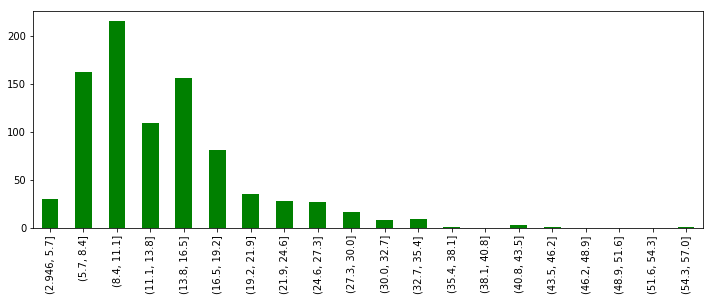

In [11]:
#View distribution of the duration by number of days
chart = pd.cut(df['ob_duration'],20)
chart.value_counts(sort=False).plot.bar(figsize=(12,4),color="g");

# Predictive Modelling

In [12]:
#11.5 days repreents a reasonable proxy for durations which are severe
#Convert to classification problem in finding severe cases
cutoff_days = 11.5

df['ob_duration'] = np.where(df['ob_duration']>cutoff_days,1,0)

In [13]:
from sklearn.model_selection import train_test_split

#Split data into training and test by desired proportion
y = df['ob_duration'].copy()
X = df.loc[:,df.columns !='ob_duration'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state = 7)

In [14]:
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None  # default='warn'

#Standardize features which require it in 'std_cols'
sc = StandardScaler()

std_cols = ['week','year','month']

std_train_df = X_train.loc[:,std_cols]
std_test_df = X_test.loc[:,std_cols]

#Fit only on train set to avoid data leakage
sc.fit(std_train_df)

#Transform both the train and test sets
X_train.loc[:,std_cols] = sc.transform(std_train_df)
X_test.loc[:,std_cols] = sc.transform(std_test_df)

In [15]:
from sklearn.decomposition import PCA

#PCA to reduce categorical features
PCA_components = [2,2]

for i in range(len(unique_values)):
    feature = unique_values['feature'].loc[i]
    cat_cols = unique_values['values'].loc[i]

    train_cat_feat = X_train[cat_cols]
    test_cat_feat = X_test[cat_cols]

    pca = PCA(n_components=PCA_components[i])

    pca.fit(train_cat_feat)
    print(pca.explained_variance_ratio_, 'Total:', pca.explained_variance_ratio_.sum().round(2))
    train_PCA = pca.transform(train_cat_feat)
    test_PCA = pca.transform(test_cat_feat)

    #Add features with new PC components and drop one-hot features
    X_train[[feature+'_PC'+str(p+1) for p in range(PCA_components[i])]] = pd.DataFrame(
        data = train_PCA, columns = [feature+'_PC'+str(p+1) for p in range(PCA_components[i])], index = X_train.index)
    
    X_test[[feature+'_PC'+str(p+1) for p in range(PCA_components[i])]] = pd.DataFrame(
        data = test_PCA, columns = [feature+'_PC'+str(p+1) for p in range(PCA_components[i])], index = X_test.index)
        
    X_train.drop(cat_cols,axis=1,inplace=True)
    X_test.drop(cat_cols,axis=1,inplace=True)

[0.16920783 0.14615255] Total: 0.32
[0.07055026 0.05431549] Total: 0.12


In [16]:
pd.options.mode.chained_assignment = None  # default='warn'

#Drop unneccesary columns after iteratively checking impact on performance
drop_cols = ['week','year','month']

X_train.drop(drop_cols,axis=1,inplace=True)
X_test.drop(drop_cols,axis=1,inplace=True)

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
        n_estimators = 100,
        max_features = 'sqrt',
        n_jobs = 4,
        random_state = 7)
    
rf_clf.fit(X_train, y_train)

#Check the variable importance
importance = rf_clf.feature_importances_
importance = pd.DataFrame(importance, 
                          columns=["importance"],
                          index = X_train.columns
                         )
importance.sort_values(by='importance',ascending=False,inplace=True)

importance[:]

,importance
postcode_PC2,0.239476
postcode_PC1,0.235169
causative_agent_PC2,0.122056
causative_agent_PC1,0.114750
LTCH,0.054571
Hospital-Acute Care,0.044173
Winter,0.032173
Hospital-Chronic Care,0.030011
Retirement Home,0.027813
Fall,0.027152


In [18]:
#Majority class results / class imbalance
y_test.value_counts()/len(y_test)

1    0.52809
0    0.47191
Name: ob_duration, dtype: float64

In [19]:
import xgboost as xgb
import warnings
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore", category=DeprecationWarning) 

gbm = xgb.XGBClassifier(max_depth=4, n_estimators=150, learning_rate=0.05).fit(X_train, y_train.ravel())
gbm_predictedValue = gbm.predict_proba(X_test)

y_pred = gbm_predictedValue[:,1]
gbm_train_pred = gbm.predict(X_train)
gbm_test_pred = gbm.predict(X_test)

print('AUC using XGBoost is {:.4f}'.format(roc_auc_score(y_test, y_pred)))
print('Accuracy of XGBoost classifier on training set: {:.3f}'
     .format(gbm.score(X_train, y_train)))
print('Accuracy of XGBoost classifier on test set: {:.3f}'
     .format(gbm.score(X_test, y_test)))

AUC using XGBoost is 0.6735
Accuracy of XGBoost classifier on training set: 0.780
Accuracy of XGBoost classifier on test set: 0.652


In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def model_results(model_name, model_predictions, y_test):
    print(model_name,'Model Evaluation')
    
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, model_predictions)))
    print('Precision: {:.3f}'.format(precision_score(y_test, model_predictions)))
    print('Recall: {:.3f}'.format(recall_score(y_test, model_predictions)))
    print('F1: {:.3f}'.format(f1_score(y_test, model_predictions)))
    print()

    print('Confusion Matrix:')
    print(pd.crosstab(y_test, model_predictions, rownames=['True'], colnames=['Predicted'], margins=True))

In [21]:
# Examine XGBoost results
model_results('XGBoost', gbm_test_pred, y_test)

XGBoost Model Evaluation
Accuracy: 0.652
Precision: 0.660
Recall: 0.702
F1: 0.680

Confusion Matrix:
Predicted   0    1  All
True                   
0          50   34   84
1          28   66   94
All        78  100  178


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

print('Logistic Regression Outputs:')
parameters = {'C':[0.01,0.1,1,10,100]}

clf = GridSearchCV(LogisticRegression(C=1), parameters).fit(X_train,y_train.values.ravel())
print ("Best Parameters:", clf.best_params_)

C = clf.best_params_['C']

print()

logr_clf = LogisticRegression(C=C).fit(X_train, y_train)
logr_predictedValue = logr_clf.predict_proba(X_test)

y_pred = logr_predictedValue[:,1]
logr_train_pred = logr_clf.predict(X_train)
logr_test_pred = logr_clf.predict(X_test)

print('AUC using Logistic Regression is {:.4f}'.format(roc_auc_score(y_test, y_pred)))
print('Accuracy of Logistic Regression classifier on training set: {:.3f}'
     .format(logr_clf.score(X_train, y_train)))
print('Accuracy of Logistic Regression classifier on test set: {:.3f}'
     .format(logr_clf.score(X_test, y_test)))

Logistic Regression Outputs:
Best Parameters: {'C': 10}

AUC using Logistic Regression is 0.6590
Accuracy of Logistic Regression classifier on training set: 0.677
Accuracy of Logistic Regression classifier on test set: 0.635


In [23]:
#Examine Logistic Regression results
model_results('Logistic Regression', logr_test_pred, y_test)

Logistic Regression Model Evaluation
Accuracy: 0.635
Precision: 0.622
Recall: 0.787
F1: 0.695

Confusion Matrix:
Predicted   0    1  All
True                   
0          39   45   84
1          20   74   94
All        59  119  178
